# Importancia de cada columna del set original

## Constantes globales 

In [74]:
TARGET = 'precio'

## Imports 

#### Import pandas, numpy and & plots 

In [75]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#### Import sklearn

In [76]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestRegressor # precio es variable continua
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

#### Import common 

In [77]:
import common.common_machine_learning as common

## Carga optimizada del set de datos 

In [78]:
train = common.cargar_set_optimizado('sets_de_datos/train.csv')

## Funciones y metodos de scoring

Mediremos cuanto depende el target : precio, de cada columna del set original: train.csv  

Funcion de scoring: 

- f_classif (ANOVA F-value)
- chi2 (X^2), 
- mutual information score.

Todas las anteriores son 'Univariate Feature Selectors'.
Puede utilizarze SelectKBest para seleccionar las K mejores features, a partir de alguna de las funciones anteriores.

Otros metodos de scoring.

- L1 regularization (Lasso Regression)
- Random Forest


Estos metodos necesitan del que los features tomen valores numericos, por lo que tendremos que transformar el set de datos mediante algun encoding:

- One Hot Encoding (Problema : puede generar muchos features)
- Label Encoding (Problema : variables numericas dan sensacion de orden)

In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 23 columns):
id                            240000 non-null int32
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipodepropiedad               239954 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float16
habitaciones                  217529 non-null float16
garages                       202235 non-null float16
banos                         213779 non-null float16
metroscubiertos               222600 non-null float16
metrostotales                 188533 non-null float16
idzona                        211379 non-null float32
lat                           116512 non-null float64
lng                           116512 non-null float64
fecha                         240

Vamos a descartar para este primer analisis las columnas de titulo, descripcion, direccion, lat, lng, fecha, idzona, que generan muchisimas sub-categorias

In [80]:
# Droppeamos strings y columnas complejas y repetidas
drop_cols = ['titulo', 'descripcion', 'direccion', 'lat', 'lng', 'fecha', 'idzona']
train_simple = train.drop(drop_cols, axis=1).copy()
train_simple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 16 columns):
id                            240000 non-null int32
tipodepropiedad               239954 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float16
habitaciones                  217529 non-null float16
garages                       202235 non-null float16
banos                         213779 non-null float16
metroscubiertos               222600 non-null float16
metrostotales                 188533 non-null float16
gimnasio                      240000 non-null bool
usosmultiples                 240000 non-null bool
piscina                       240000 non-null bool
escuelascercanas              240000 non-null bool
centroscomercialescercanos    240000 non-null bool
precio                        240000 non-null float32
dtypes: bool(5), float16(6), float32(1), int3

In [81]:
train_simple.columns

Index(['id', 'tipodepropiedad', 'ciudad', 'provincia', 'antiguedad',
       'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

In [82]:
print('Cantidad de categorias en tiposdepropiedad : ' + str(train_simple['tipodepropiedad'].value_counts().count()))
print('Cantidad de categorias en provincia : ' + str(train_simple['provincia'].value_counts().count()))
print('Cantidad de categorias en ciudad : ' + str(train_simple['ciudad'].value_counts().count()))

Cantidad de categorias en tiposdepropiedad : 24
Cantidad de categorias en provincia : 32
Cantidad de categorias en ciudad : 875


Aproximandamente tenemos 900 categorias que codificar.  
Si usamos One Hot Encoding, entonces estariamos agregando 900 columnas a nuestro set de datos. si bien dependiendo de la  computadora podria bancarselo o no, el resultado no seria que lo que se quisiese analizar.  
Por lo tanto, si bien el modelo podria predecir mal, vamos a utilizar Label Encoding.

In [83]:
cat_features = ['tipodepropiedad', 'provincia', 'ciudad']

label_encoder = LabelEncoder()

for cat in cat_features:
    train_simple = train_simple.fillna(value = {cat : 'NaN'})
    train_simple[cat] = label_encoder.fit_transform(train_simple[cat])    

In [84]:
train_simple.head()

,id,tipodepropiedad,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
0,254099,0,93,8,NaN,2.0,1.0,2.0,80.0,80.0,False,False,False,False,False,2273000.0
1,53461,3,370,8,10.0,3.0,2.0,2.0,268.0,180.0,False,False,False,True,True,3600000.0
2,247984,2,768,14,5.0,3.0,2.0,2.0,144.0,166.0,False,False,False,False,False,1200000.0
3,209067,2,862,10,1.0,2.0,1.0,1.0,63.0,67.0,False,False,False,True,True,650000.0
4,185997,0,852,14,10.0,2.0,1.0,1.0,95.0,95.0,False,False,False,False,False,1150000.0


In [85]:
feature_cols = train_simple.columns.drop(TARGET)
train_simple_X = train_simple.drop([TARGET], axis=1)
train_simple_y = train_simple[TARGET]
train_simple_X_train, train_simple_X_test,\
    train_simple_y_train, train_simple_y_test = train_test_split(
                                                    train_simple_X, 
                                                    train_simple_y, 
                                                    test_size=0.25, 
                                                    random_state=1)

Solo vamos a usar train_X_train e train_y_train

### Imputar nulls numericos 

In [86]:
imp_mean = SimpleImputer()

Optamos por reemplazar NaN con el promedio, sin ninguna justificacion

In [87]:
cols_con_nulls = list(set(train_simple.columns[train_simple.isnull().sum() > 0].tolist()) \
                                  - set(cat_features))

In [88]:
train_simple_X_train = train_simple_X_train.copy()
train_simple_X_test = train_simple_X_test.copy()
for col in cols_con_nulls:
    train_simple_X_train[col] = imp_mean.fit_transform(train_simple_X_train[[col]])  
    train_simple_X_test[col] = imp_mean.fit_transform(train_simple_X_test[[col]])

### f_classif

In [89]:
selector = SelectKBest(f_classif, k=3)

train_simple_X_new_train = selector.fit_transform(train_simple_X_train, train_simple_y_train)
train_simple_X_new_train

array([[2.0, 315.0, 315.0],
       [2.0, 85.0, 176.9162466374062],
       [4.0, 130.0, 176.9162466374062],
       ...,
       [3.0, 174.16319011789514, 300.0],
       [2.0, 135.0, 154.0],
       [2.0, 300.0, 176.9162466374062]], dtype=object)

In [90]:
train_simple.shape

(240000, 16)

In [91]:
train_X_new.shape

(180000, 3)

In [92]:
feature_cols

Index(['id', 'tipodepropiedad', 'ciudad', 'provincia', 'antiguedad',
       'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos'],
      dtype='object')

In [93]:
selector.scores_

array([ 0.99563701,  2.89433145,  1.35299759,  1.62585823,  0.92108249,
        2.63636534,  3.67418034,  8.7685028 , 12.6146207 ,  5.91204182,
        1.89231338,  1.82397032,  1.64763219,  1.0357918 ,  1.02119959])

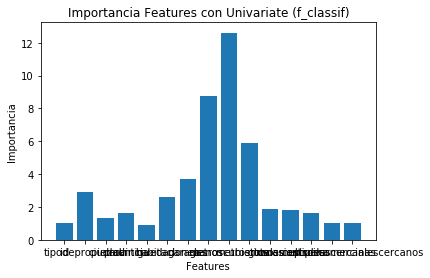

In [94]:
plt.bar(feature_cols, selector.scores_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Univariate (f_classif)')
plt.show()

In [100]:
selected_features = pd.DataFrame(selector.inverse_transform(train_simple_X_new_train), 
                                 index=train_simple_X_train.index, 
                                 columns=feature_cols)
selected_features.head()

,id,tipodepropiedad,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos
193355,0,0,0,0,0,0,0,2,315,315,0,0,0,0,0
76494,0,0,0,0,0,0,0,2,85,176.916,0,0,0,0,0
205960,0,0,0,0,0,0,0,4,130,176.916,0,0,0,0,0
65931,0,0,0,0,0,0,0,4,408,176.916,0,0,0,0,0
83352,0,0,0,0,0,0,0,1,194,120,0,0,0,0,0


In [101]:
selected_columns = selected_features.columns[selected_features.var() != 0]

In [102]:
selected_columns

Index(['banos', 'metroscubiertos', 'metrostotales'], dtype='object')

In [104]:
train_simple_X_test[selected_columns].head()

,banos,metroscubiertos,metrostotales
132827,2.000000,172.0,110.0
210008,2.000000,76.0,76.0
189056,2.131322,245.0,170.0
131466,1.000000,185.0,145.0
207302,1.000000,40.0,90.0


### chi2

In [ ]:
selector_chi2 = SelectKBest(chi2, k=3)

X_new = selector_chi2.fit_transform(train[feature_cols], train['outcome'])

In [ ]:
selector_chi2.scores_

In [ ]:
plt.bar(feature_cols, selector_chi2.scores_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Univariate (chi2)')
plt.show()

In [ ]:
plt.bar(feature_cols[1:], selector_chi2.scores_[1:])
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Univariate (chi2)')
plt.show()

### mutual_info_classif

In [ ]:
selector_mutual = SelectKBest(mutual_info_classif, k=3)

X_new = selector_mutual.fit_transform(train[feature_cols], train['outcome'])

In [ ]:
plt.bar(feature_cols, selector_mutual.scores_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Univariate (mutual)')
plt.show()

## L1 regularization (Lasso Regression)

Penalización al aumentar la complejidad del modelo

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

train, valid, _ = get_data_splits(baseline_data)

X, y = train[train.columns.drop("outcome")], train['outcome']

# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l1", random_state=7).fit(X, y)

In [ ]:
logistic.coef_

In [ ]:
plt.bar(feature_cols, logistic.coef_[0])
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Lasso')
plt.show()

In [ ]:
model = SelectFromModel(logistic, prefit=True, max_features=3)

X_new = model.transform(X)

In [ ]:
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=train.index, 
                                 columns=feature_cols)
selected_features.head()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

X, y = train[train.columns.drop("outcome")], train['outcome']
val_X, val_y = valid[valid.columns.drop("outcome")], valid['outcome']

forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X, y)
preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, preds))

In [ ]:
forest_model.feature_importances_

In [ ]:
plt.bar(feature_cols, forest_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

In [ ]:
model = SelectFromModel(forest_model, prefit=True, max_features=3)

X_new = model.transform(X)

In [ ]:
X_new